### Importing Necessary Libaries

In [144]:
import numpy as np
import pandas as pd
import gdown as epoch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Loading the DataSet:
* I uploaded the file in my google drive
* Using ```gdown```, I am downloading the dataset.
* Then converting .csv into pandas dataframe.
* Printing its intial value.

In [145]:
link = 'https://drive.google.com/file/d/1J9mXIg2lYn-BeBKYqpJvPLpBssxZRiwe/view?usp=drive_link'
file_id = "1J9mXIg2lYn-BeBKYqpJvPLpBssxZRiwe"
url = f"https://drive.google.com/uc?id={file_id}"
file = "data.csv"

epoch.download(url, file, quiet=False)

clustering_df = pd.read_csv(file)

Downloading...
From: https://drive.google.com/uc?id=1J9mXIg2lYn-BeBKYqpJvPLpBssxZRiwe
To: /content/data.csv
100%|██████████| 19.9M/19.9M [00:00<00:00, 80.0MB/s]
<ipython-input-145-d6623d4d9305>:8: DtypeWarning:

Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.



### Filtering Home State using CircleName: PUNJAB

In [146]:
filtered_df = clustering_df[clustering_df['CircleName'] == "Punjab Circle"]
print(filtered_df.shape)
filtered_df.head()

(3894, 11)


,CircleName,RegionName,DivisionName,OfficeName,Pincode,OfficeType,Delivery,District,StateName,Latitude,Longitude
181,Punjab Circle,NaN,Patiala Division,SWAI SINGH WALA B.O,147111,BO,Delivery,PATIALA,PUNJAB,30.2204,76.4964
182,Punjab Circle,NaN,Patiala Division,BINJAL B.O,147111,BO,Delivery,PATIALA,PUNJAB,30.1407,76.6146
380,Punjab Circle,Punjab West Region,Faridkot Division,Smalsar S.O,142049,PO,Delivery,MOGA,PUNJAB,30.6389875,74.9985706
431,Punjab Circle,Punjab West Region,Faridkot Division,Golewala S.O,151214,PO,Delivery,FARIDKOT,PUNJAB,30.790411,74.699154
791,Punjab Circle,DivReportingCircle,Ludhiana Moffusil Division,BALION BO,141114,BO,Delivery,LUDHIANA,PUNJAB,30.8607,76.1863


### Analyzing the Data:
1. The data is about various post office all across the state.
2. We are given with the position of the postoffice (in terms of longitude and latitude).
3. We have if the office is deliverable or Non deliverable(acts as a hub only).
4. Then we have three types of offices
  * HO: HOs are the primary hubs for postal services in an area, handling a wider range of services and mail.
  * PO: Located in smaller towns or specific areas.
  * BO: Located in rural areas.

### Converting Latitude and Longitude to numeric values:

In [147]:
filtered_df.loc[:, 'Latitude'] = pd.to_numeric(filtered_df['Latitude'], errors='coerce')
filtered_df.loc[:, 'Longitude'] = pd.to_numeric(filtered_df['Longitude'], errors='coerce')
filtered_df = filtered_df.dropna(subset= ['Latitude', 'Longitude'])

### Printing Range of Longitude and Lattitude:
* Here we observe that Longitude ranges from 0.5 to 153 and Latitude ranges from 4 to 3194 which is obviously not possible.
* So I concluded that there are few outliers which have CircleName as Punjab Circle but they definetely not lie in Punjab.
* Now I googled out rough longitude and latitude range of Punjab and applied boundaries on allowed Longitude and Lattitude values

In [148]:
print(f"Longitude Ranges from {filtered_df.loc[:, 'Longitude'].min()} to {filtered_df.loc[:, 'Longitude'].max()}")
print(f"Latitude Ranges from {filtered_df.loc[:, 'Latitude'].min()} to {filtered_df.loc[:, 'Latitude'].max()}")

punjab_df = filtered_df[
    (filtered_df['Latitude'] >= 29.5) & (filtered_df['Latitude'] <= 32.53) &
    (filtered_df['Longitude'] >= 73.92) & (filtered_df['Longitude'] <= 76.83)
].copy()
punjab_df.shape

Longitude Ranges from 0.594265 to 153.456198
Latitude Ranges from 4.321015 to 3194.0


(3685, 11)

### Checking if there are any null values and removing them

In [149]:
punjab_df.isnull().sum()

,0
CircleName,0
RegionName,2
DivisionName,0
OfficeName,0
Pincode,0
OfficeType,0
Delivery,0
District,0
StateName,0
Latitude,0


In [150]:
punjab_df = punjab_df.dropna(subset = ['RegionName'])

### Visualizing the points on map:
1. I could have used libraries like "folium" to have interactive and highly accurate map.
2. But to do something unique I decided to stick to matplotlib only.
3. So the idea now is to have punjab map in the background and plot the points over it.
4. To get the image of exact region of punjab between the given latitudes and longitudes, I used [OpenStreetMap](https://www.openstreetmap.org/#map=5/21.84/82.79)
5. Then i just plotted the points using ```plt.scatter```

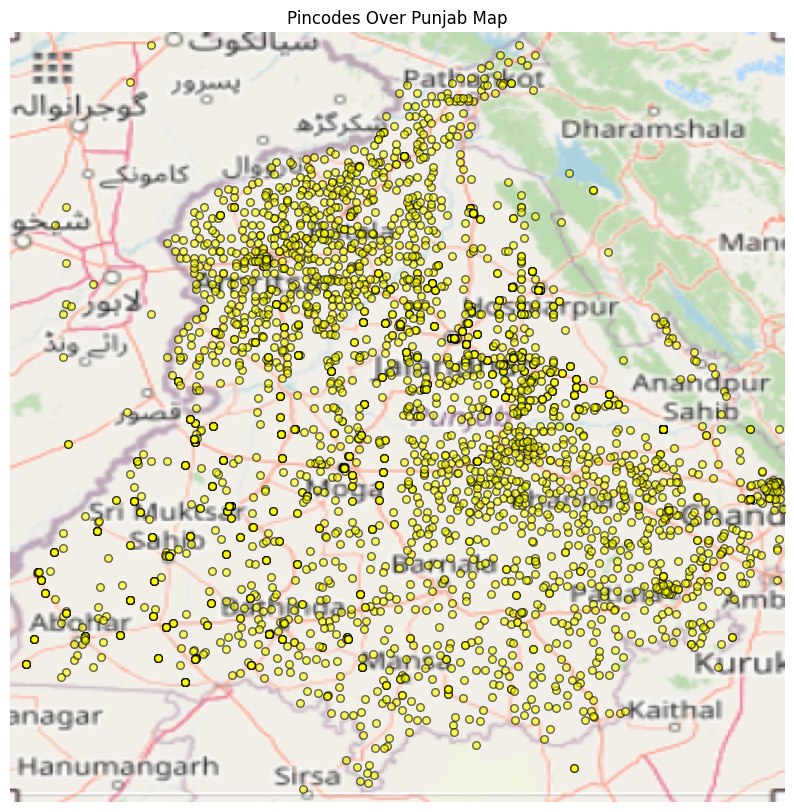

In [151]:
img = mpimg.imread('funjab.png')
extent = [73.92, 76.83, 29.5, 32.53]
plt.figure(figsize=(10, 10))
plt.imshow(img, extent=extent, aspect='auto')

plt.scatter(
    punjab_df['Longitude'],
    punjab_df['Latitude'],
    c='yellow',
    s=30,
    alpha=0.6,
    edgecolors='black'
)

plt.title("Pincodes Over Punjab Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis(False)
plt.show()

### Implementing K-means Clustering (Approach -  1)

In this approach I will just use Latitude and Longitude as features.

In [152]:
X = punjab_df[['Latitude', 'Longitude']].astype(float).values
X

array([[30.6389875, 74.9985706],
       [30.790411 , 74.699154 ],
       [30.8607   , 76.1863   ],
       ...,
       [31.62     , 74.91     ],
       [31.63     , 74.88     ],
       [31.6386   , 74.8826   ]])

### Inside ```initializse_centroids```
1. Choosing $k$ indices.
2. Choosing corresponding from X.

### Inside ```assign_clusters```
1. Takes X and centroid array as arguments.
2. For each point in X, we assign the centroid nearest to it
3. Return the labels(centroid corresponding to each point).

In [153]:
def initialize_centroids(X, k):
  np.random.seed(864)
  indices = np.random.choice(len(X), size=k, replace=False)
  return X[indices]

def assign_clusters(X, centroids):
  labels = []
  for point in X:
      distances = [np.linalg.norm(point - c) for c in centroids]
      closest_centroid = np.argmin(distances)
      labels.append(closest_centroid)
  return np.array(labels)

### Inside ```update_centroids```:
1. It loops over each cluster.
2. For each cluster $i$, it selects the data points in X that belong to that cluster (i.e., where labels $== i$).
3. It calculates the mean of those points — this becomes the new centroid.
4. Collects all new centroids into a list and returns them as a NumPy array.

In [154]:
def update_centroids(X, labels, k):
  new_centroids = []
  for i in range(k):
      cluster_points = X[labels == i]
      new_centroid = np.mean(cluster_points, axis=0)
      new_centroids.append(new_centroid)
  return np.array(new_centroids)

### Inside ```kmeans``` :
1. Initialize centroids randomly from data.
2. Loop up to max_iters:

  * Assign clusters: Based on current centroids, assign each point to the nearest cluster.

  * Update centroids: Compute new centroids by averaging the points in each cluster.

  * Check for convergence: If centroids don’t change much (based on tol), stop.

3. Return final centroids and labels.

In [155]:
def kmeans(X, k, max_iters=100, tol=1e-4):
  centroids = initialize_centroids(X, k)
  for i in range(max_iters):
      labels = assign_clusters(X, centroids)
      new_centroids = update_centroids(X, labels, k)
      if np.linalg.norm(new_centroids - centroids) < tol:
          print(f"Converged after {i+1} iterations")
          break

      centroids = new_centroids
  return centroids, labels

### Choosing k:
1. Here I observed that there are 21 HO's in Punjab.
2. I am choosing $k = 21$ in hopes to observe pattern.

In [156]:
(punjab_df['OfficeType'] == 'HO').sum()

np.int64(21)

### Calling ```kmeans``` function.

In [157]:
k = 21
centroids, labels = kmeans(X, k)

Converged after 26 iterations


### Plotting:
1. First we plot all the points and give them different colors based on clusters.
2. Then we will plot all the centroids.
3. Then we will plot all the points which has ```OfficeType = HO ```.

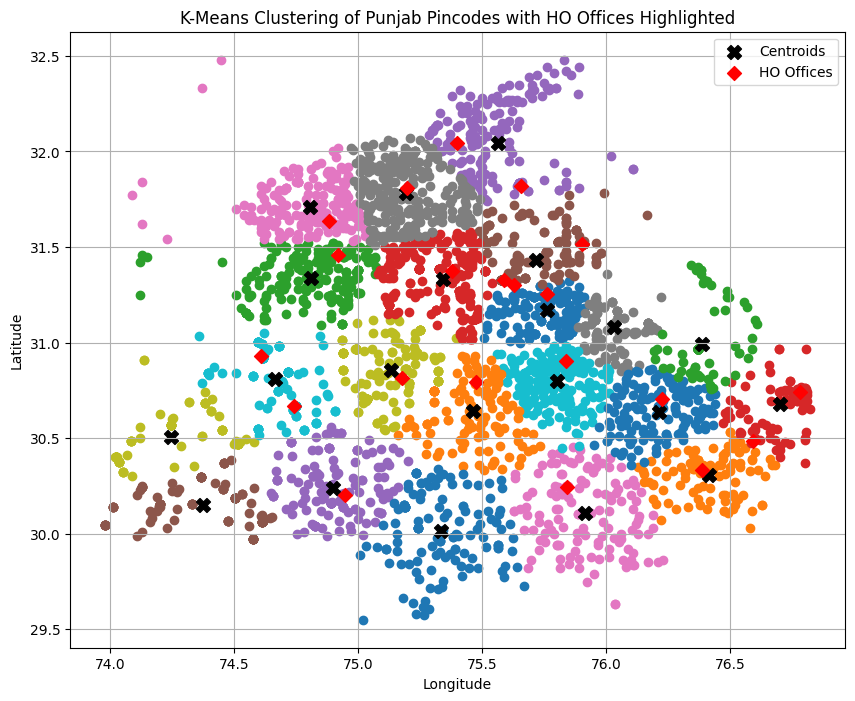

In [158]:
plt.figure(figsize=(10, 8))

for i in range(k):
    plt.scatter(X[labels == i, 1], X[labels == i, 0])

plt.scatter(centroids[:, 1], centroids[:, 0], color='black', marker='X', s=100, label='Centroids')

ho_data = punjab_df[punjab_df['OfficeType'] == 'HO']
plt.scatter(ho_data['Longitude'], ho_data['Latitude'], color='red', marker='D', s=50, label='HO Offices')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clustering of Punjab Pincodes with HO Offices Highlighted')
plt.legend()
plt.grid(True)
plt.show()

### Observations:
1. We see most of the clusters have $1$ HO office.
2. Many centroids are very close to the respective HO office.

### Interpretations:
1. Most of the clusters are like a subdivision inside the state.
2. Each subdivision has $1$ HO office which is like head of the subdivison.
3. Each Subdivision has many PO and BO office.

### Some more Visualization:

### Office Type Representation for each cluster
* We see in each cluster, $75\% - 85\%$ of the post offices are BO.
* Around $15\%$ of the post offices are PO.
* Each cluster has 1 HO Post office.

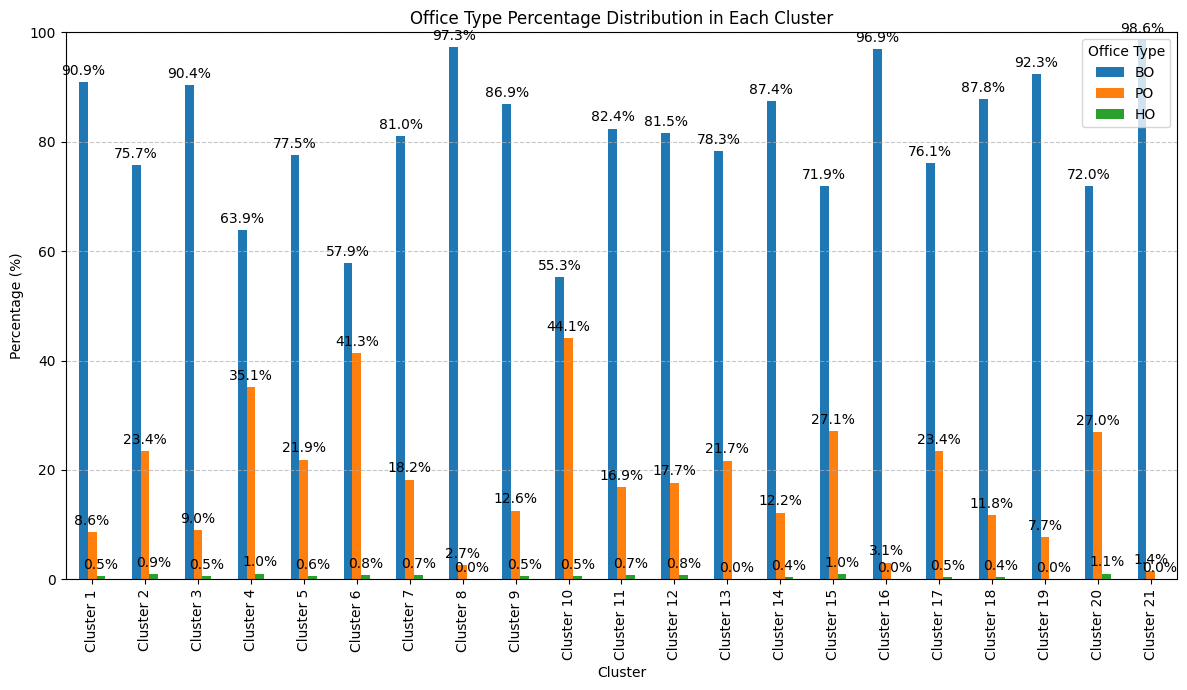

In [159]:
punjab_df['Cluster'] = labels

clusters = sorted(punjab_df['Cluster'].unique())
office_types = ['BO', 'PO', 'HO']

data = []
for cluster in clusters:
    cluster_data = punjab_df[punjab_df['Cluster'] == cluster]
    total = len(cluster_data)
    row = {'Cluster': f'Cluster {cluster+1}'}
    for ot in office_types:
        count = (cluster_data['OfficeType'] == ot).sum()
        row[ot] = (count / total) * 100
    data.append(row)

df_plot = pd.DataFrame(data)

ax = df_plot.set_index('Cluster').plot(kind='bar', figsize=(12, 7), color=['#1f77b4', '#ff7f0e', '#2ca02c'])

plt.title('Office Type Percentage Distribution in Each Cluster')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
plt.legend(title='Office Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

### Delivery vs Non Delivery Post Office each clusters
* Around $85\%$ of the post offices are deliverable.
* Rest of them acts as a hub(non-deliverable).

<Axes: xlabel='Cluster'>

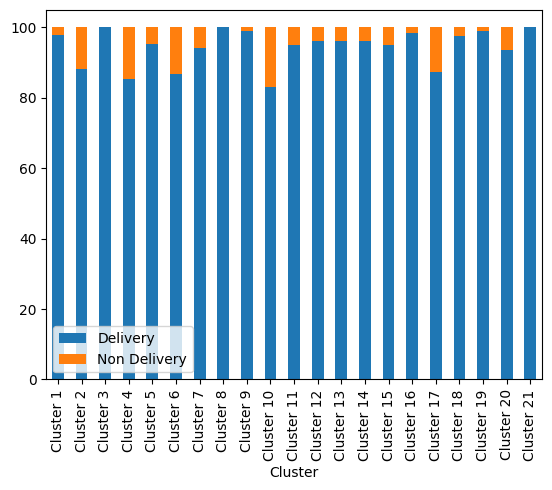

In [160]:
delivery_data = []
for cluster in clusters:
    cluster_data = punjab_df[punjab_df['Cluster'] == cluster]
    total = len(cluster_data)
    row = {'Cluster': f'Cluster {cluster+1}'}
    for status in ['Delivery', 'Non Delivery']:
        count = (cluster_data['Delivery'] == status).sum()
        row[status] = (count / total) * 100
    delivery_data.append(row)

pd.DataFrame(delivery_data).set_index('Cluster').plot(kind='bar', stacked=True)


### Distribution of PO, BO and HO across the state
* In south and south-western region observe there are less PO and HO offices, it can refer to the fact that region has not been properly urbanized yet.
* Note there is overall less density of post offices in that region too.
* We can also say that North punjab has more urban centre than south punjab.


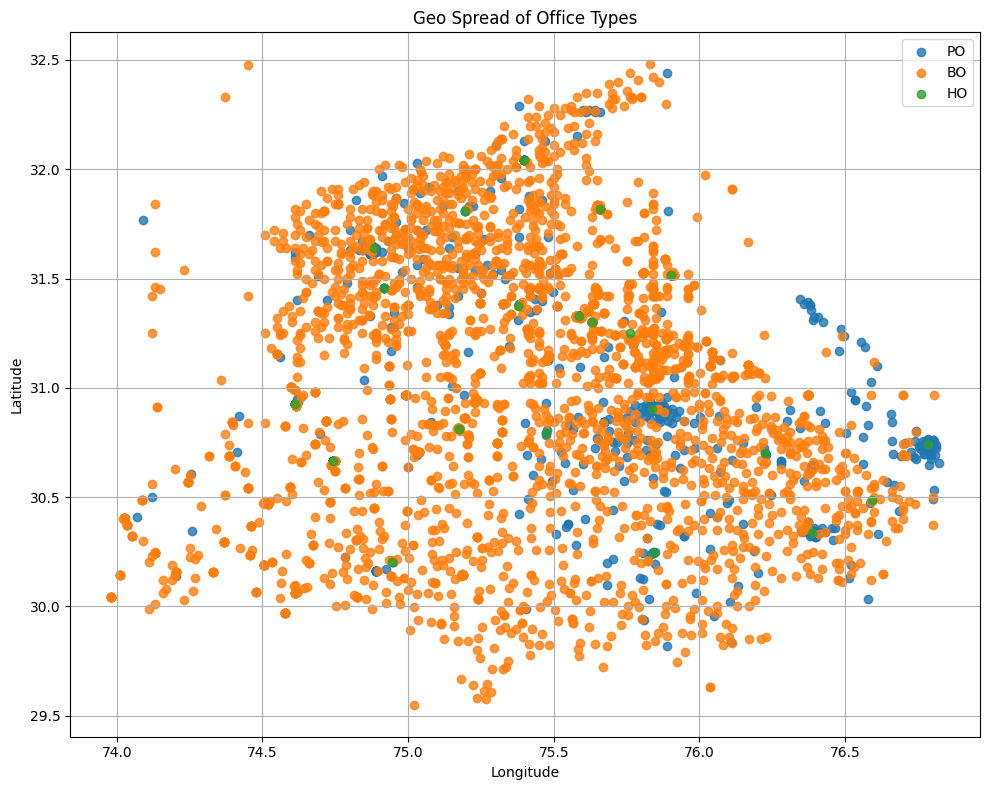

In [161]:
color_map = {'BO': 'blue', 'PO': 'green', 'HO': 'red'}
plt.figure(figsize=(10, 8))
for office_type in punjab_df['OfficeType'].unique():
    subset = punjab_df[punjab_df['OfficeType'] == office_type]
    plt.scatter(subset['Longitude'], subset['Latitude'], label=office_type, alpha=0.8)
plt.legend()
plt.title('Geo Spread of Office Types')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.show()
